In [15]:
import time
import json
import torch
from transformers import RTDetrImageProcessor
from PIL import Image, ImageDraw

import tensorrt as trt
from tensorrtinference import TensorRTInference

In [16]:
with open('labels.txt', 'r') as f:
    labels = json.loads(f.read())
    
print(labels)

{'0': 'person', '1': 'bicycle', '2': 'car', '3': 'motorbike', '4': 'aeroplane', '5': 'bus', '6': 'train', '7': 'truck', '8': 'boat', '9': 'traffic light', '10': 'fire hydrant', '11': 'stop sign', '12': 'parking meter', '13': 'bench', '14': 'bird', '15': 'cat', '16': 'dog', '17': 'horse', '18': 'sheep', '19': 'cow', '20': 'elephant', '21': 'bear', '22': 'zebra', '23': 'giraffe', '24': 'backpack', '25': 'umbrella', '26': 'handbag', '27': 'tie', '28': 'suitcase', '29': 'frisbee', '30': 'skis', '31': 'snowboard', '32': 'sports ball', '33': 'kite', '34': 'baseball bat', '35': 'baseball glove', '36': 'skateboard', '37': 'surfboard', '38': 'tennis racket', '39': 'bottle', '40': 'wine glass', '41': 'cup', '42': 'fork', '43': 'knife', '44': 'spoon', '45': 'bowl', '46': 'banana', '47': 'apple', '48': 'sandwich', '49': 'orange', '50': 'broccoli', '51': 'carrot', '52': 'hot dog', '53': 'pizza', '54': 'donut', '55': 'cake', '56': 'chair', '57': 'sofa', '58': 'pottedplant', '59': 'bed', '60': 'dinin

In [11]:
trt_logger = trt.Logger(trt.Logger.WARNING)

In [12]:
builder = trt.Builder(trt_logger)

In [13]:
config = builder.create_builder_config()
config.set_memory_pool_limit(trt.MemoryPoolType.WORKSPACE, (1 << 50))
config.set_flag(trt.BuilderFlag.FP16)
# config.set_flag(trt.BuilderFlag.INT8)
config.default_device_type = trt.DeviceType.GPU

In [14]:
flag = 1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
network = builder.create_network(flag)

In [15]:
parser = trt.OnnxParser(network, trt_logger)
path_onnx_model = "model.onnx"
with open(path_onnx_model, "rb") as f:
    if not parser.parse(f.read()):
        print(f"ERROR: Failed to parse the ONNX file {path_onnx_model}")
        for error in range(parser.num_errors):
            print(parser.get_error(error))

inputs = [network.get_input(i) for i in range(network.num_inputs)]
outputs = [network.get_output(i) for i in range(network.num_outputs)]
for input in inputs:
    print(f"Model {input.name} shape: {input.shape} {input.dtype}")
    
for output in outputs:
    print(f"Model {output.name} shape: {output.shape} {output.dtype}") 

Model images shape: (1, 3, 480, 640) DataType.FLOAT
Model scores shape: (1, 300, 80) DataType.FLOAT
Model labels shape: (1, 300, 4) DataType.FLOAT
Model boxes shape: (1, 300, 256) DataType.FLOAT
Model 2823 shape: (1, 3, 300, 256) DataType.FLOAT
Model onnx::Gather_2837 shape: (1, 3, 300, 80) DataType.FLOAT
Model onnx::Gather_2830 shape: (1, 3, 300, 4) DataType.FLOAT
Model input.332 shape: (1, 256, 60, 80) DataType.FLOAT
Model input.424 shape: (1, 256, 30, 40) DataType.FLOAT
Model input.516 shape: (1, 256, 15, 20) DataType.FLOAT
Model reference_points_unact shape: (1, 300, 4) DataType.FLOAT
Model 1574 shape: (1, 300, 80) DataType.FLOAT
Model 1554 shape: (1, 300, 4) DataType.FLOAT
Model onnx::ReduceMax_1513 shape: (1, 6300, 80) DataType.FLOAT
Model onnx::GatherElements_1525 shape: (1, 6300, 4) DataType.FLOAT


In [16]:
engine_bytes = builder.build_serialized_network(network, config)
with open("model.trt", 'wb') as f:
    f.write(bytearray(engine_bytes))

## Inference

In [17]:
trt_inference = TensorRTInference("model.trt")

In [18]:
image_processor = RTDetrImageProcessor.from_pretrained("jadechoghari/RT-DETRv2")

In [19]:
start = time.time()
img = Image.open("000000039769.jpg")
image_processor.size = {'height': 480, 'width': 640}
input_tensor = image_processor(img, return_tensors="pt")
end = time.time()
print(end - start)

0.008508682250976562


In [20]:
start = time.time()
# output_data = trt_inference.infer(input_data)
output_data = trt_inference.infer(input_tensor['pixel_values'])
# output_data = trt_inference(input_data)
end = time.time()
print(end - start)

0.0075147151947021484


In [21]:
from dataclasses import dataclass

@dataclass
class DetrOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor

In [22]:
start = time.time()
detr_output = DetrOutput(logits = torch.from_numpy(output_data[0].host.reshape((1, -1, 80))),
                         pred_boxes = torch.from_numpy(output_data[1].host.reshape((1, -1, 4))))
results = image_processor.post_process_object_detection(detr_output, target_sizes=torch.tensor([img.size[::-1]]), threshold=0.3)
end = time.time()
print(end - start)

0.0015079975128173828


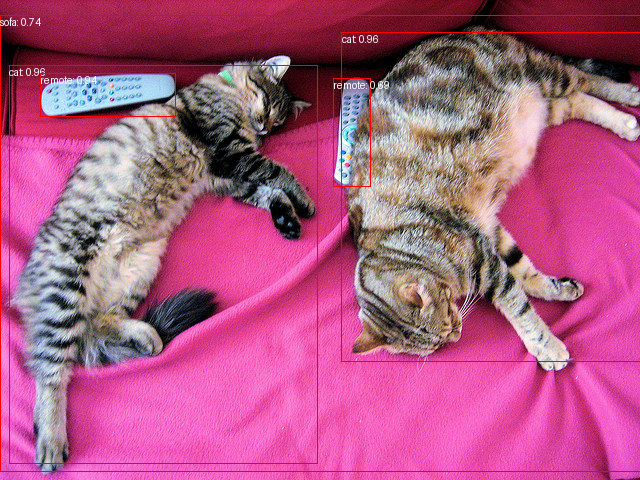

In [13]:
draw_img2 = img.copy()
draw = ImageDraw.Draw(draw_img2)

for result in results:
    for score, label_id, box in zip(result["scores"], result["labels"], result["boxes"]):
        score, label = score.item(), label_id.item()
        box = [round(i, 2) for i in box.tolist()]
        if score > 0.5:
            draw.rectangle(box, fill=None, outline='red')
            draw.text((box[0], box[1]), f"{labels[str(label)]}: {score:.2f}")

display(draw_img2)